In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna 
from sklearn.model_selection import StratifiedKFold, train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# ignore warning for cleaner output
warnings.filterwarnings('ignore')
# same goes for otuna for error handling 
optuna.logging.set_verbosity(optuna.logging.WARNING)

Load data

In [5]:
try:
    # Training data
    orders = pd.read_csv('Train/orders.csv')
    train_customers = pd.read_csv('Train/train_customers.csv')
    train_locations = pd.read_csv('Train/train_locations.csv')
    vendors = pd.read_csv('Train/vendors.csv')

    # Testing data
    test_customers = pd.read_csv('Test/test_customers.csv')
    test_locations = pd.read_csv('Test/test_locations.csv')
    
    # Sample submission for structure
    sample_submission = pd.read_csv('SampleSubmission.csv')
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please ensure your data files are in the 'Train' and 'Test' subdirectories.")
    exit()

Data loaded successfully.


In [ ]:
# --- Memory Optimization & Initial Cleaning ---
orders.rename(columns={'LOCATION_NUMBER': 'location_number'}, inplace=True) 
orders = orders.drop(columns=['vendor_rating', 'LOCATION_TYPE'], errors='ignore')

# Convert columns to memory-efficient types
orders['item_count'] = pd.to_numeric(orders['item_count'], errors='coerce').astype('float16')
orders['grand_total'] = pd.to_numeric(orders['grand_total'], errors='coerce').astype('float32')
train_locations['location_number'] = pd.to_numeric(train_locations['location_number'], errors='coerce').astype('int8')
test_locations['location_number'] = pd.to_numeric(test_locations['location_number'], errors='coerce').astype('int8')
orders['location_number'] = pd.to_numeric(orders['location_number'], errors='coerce').astype('int8')

vendors['vendor_id'] = vendors['id']
vendors['vendor_rating'] = pd.to_numeric(vendors['vendor_rating'], errors='coerce').astype('float16')
print("Memory optimized and columns cleaned.")

Step 2/11: Optimizing memory and cleaning columns...
Memory optimized and columns cleaned.


 Advanced Feature Engineering

In [7]:
# Time-based features
orders['created_at'] = pd.to_datetime(orders['created_at'])
orders['order_hour'] = orders['created_at'].dt.hour
orders['order_dayofweek'] = orders['created_at'].dt.dayofweek

In [8]:
# Create aggregated time features 
customer_time_prefs = orders.groupby('customer_id').agg(
    cust_avg_hour=('order_hour', 'mean'),
    cust_avg_day=('order_dayofweek', 'mean')
)
vendor_time_prefs = orders.groupby('vendor_id').agg(
    vendor_avg_hour=('order_hour', 'mean'),
    vendor_avg_day=('order_dayofweek', 'mean')
)

In [9]:
# Customer behavior features
orders = orders.sort_values(['customer_id', 'created_at'])
orders['time_since_last_order'] = orders.groupby('customer_id')['created_at'].diff().dt.total_seconds() / 3600 # in hours
customer_time_agg = orders.groupby('customer_id')['time_since_last_order'].agg(['mean', 'std']).rename(columns={'mean': 'cust_mean_time_between_orders', 'std': 'cust_std_time_between_orders'})


In [10]:
# Popularity features
vendor_popularity = orders['vendor_id'].value_counts().to_frame('vendor_popularity_rank')
customer_spending_rank = orders.groupby('customer_id')['grand_total'].sum().rank(ascending=False).to_frame('customer_spending_rank')

In [11]:
# --- Vendor Features ---
vendors['vendor_tag_count'] = vendors['vendor_tag_name'].str.count(',') + 1
vendors_cleaned = vendors[['vendor_id', 'latitude', 'longitude', 'vendor_rating', 'serving_distance', 'prepration_time', 'vendor_tag_count']].rename(columns={'latitude': 'vendor_latitude', 'longitude': 'vendor_longitude'})
vendors_cleaned = vendors_cleaned.merge(vendor_popularity, left_on='vendor_id', right_index=True, how='left')
vendors_cleaned = vendors_cleaned.merge(vendor_time_prefs, left_on='vendor_id', right_index=True, how='left')

In [12]:
# --- Customer Features ---
all_customers = pd.concat([train_customers, test_customers], ignore_index=True)
all_customers['dob'] = pd.to_numeric(all_customers['dob'], errors='coerce')
all_customers['age'] = 2025 - all_customers['dob']
all_customers['age'].fillna(all_customers['age'].median(), inplace=True)
all_customers['created_at'] = pd.to_datetime(all_customers['created_at'], errors='coerce')
all_customers['account_age_days'] = (pd.to_datetime('2025-08-01') - all_customers['created_at']).dt.days
all_customers['gender'].fillna('Unknown', inplace=True)
le_gender = LabelEncoder()
all_customers['gender_encoded'] = le_gender.fit_transform(all_customers['gender'])
customers_cleaned = all_customers[['customer_id', 'age', 'account_age_days', 'gender_encoded']]
customers_cleaned = customers_cleaned.merge(customer_spending_rank, left_on='customer_id', right_index=True, how='left')
customers_cleaned = customers_cleaned.merge(customer_time_agg, left_on='customer_id', right_index=True, how='left')
customers_cleaned = customers_cleaned.merge(customer_time_prefs, left_on='customer_id', right_index=True, how='left')

In [13]:
# --- Location Features ---
all_locations = pd.concat([train_locations, test_locations], ignore_index=True)

In [14]:
# --- Merge Orders with Features ---
train_df = orders.merge(customers_cleaned, on='customer_id', how='left')
train_df = train_df.merge(all_locations, on=['customer_id', 'location_number'], how='left')
train_df = train_df.merge(vendors_cleaned, on='vendor_id', how='left')
train_df['target'] = 1

Negative Sampling 

In [15]:

all_vendor_ids = vendors['vendor_id'].unique()
customer_vendor_pairs = train_df[['customer_id', 'vendor_id']].drop_duplicates()
all_combinations = pd.DataFrame(np.array(np.meshgrid(train_df['customer_id'].unique(), all_vendor_ids)).T.reshape(-1, 2), columns=['customer_id', 'vendor_id'])
negative_samples = all_combinations.merge(customer_vendor_pairs, on=['customer_id', 'vendor_id'], how='left', indicator=True)
negative_samples = negative_samples[negative_samples['_merge'] == 'left_only']
num_positive_samples = len(train_df)
negative_samples = negative_samples.sample(n=num_positive_samples * 2, random_state=42)
negative_samples['target'] = 0
train_full = pd.concat([train_df, negative_samples], ignore_index=True)

In [16]:
# Fill in missing features for the negative samples
cols_to_drop = [col for col in customers_cleaned.columns if col != 'customer_id'] + \
               [col for col in vendors_cleaned.columns if col != 'vendor_id'] + \
               ['latitude', 'longitude', 'location_type']
train_full = train_full.drop(columns=[col for col in cols_to_drop if col in train_full.columns])
train_full = train_full.merge(customers_cleaned, on='customer_id', how='left')
primary_locations = all_locations[all_locations['location_number'] == 0]
train_full = train_full.merge(primary_locations.drop(columns='location_number'), on='customer_id', how='left')
train_full = train_full.merge(vendors_cleaned, on='vendor_id', how='left')

Feature Engineering on the Combined Dataset

In [17]:
train_full['distance_km'] = np.sqrt((train_full['latitude'] - train_full['vendor_latitude'])**2 + (train_full['longitude'] - train_full['vendor_longitude'])**2)
customer_agg = train_df.groupby('customer_id')['grand_total'].agg(['mean', 'count']).rename(columns={'mean': 'cust_avg_order_val', 'count': 'cust_order_count'})
vendor_agg = train_df.groupby('vendor_id')['grand_total'].agg(['mean', 'count']).rename(columns={'mean': 'vendor_avg_order_val', 'count': 'vendor_order_count'})
train_full = train_full.merge(customer_agg, on='customer_id', how='left')
train_full = train_full.merge(vendor_agg, on='vendor_id', how='left')

In [18]:
# Fill NaNs for all generated features
for col in ['cust_avg_order_val', 'cust_order_count', 'vendor_avg_order_val', 'vendor_order_count', 
            'vendor_popularity_rank', 'customer_spending_rank', 'cust_mean_time_between_orders', 
            'cust_std_time_between_orders', 'cust_avg_hour', 'cust_avg_day', 'vendor_avg_hour', 'vendor_avg_day']:
    train_full[col].fillna(0, inplace=True)

Preparing data for the model

In [19]:
features = [
    'age', 'account_age_days', 'gender_encoded', 'customer_spending_rank',
    'cust_avg_order_val', 'cust_order_count', 'cust_mean_time_between_orders',
    'cust_avg_hour', 'cust_avg_day',
    'vendor_rating', 'serving_distance', 'prepration_time', 'vendor_tag_count',
    'vendor_avg_order_val', 'vendor_order_count', 'vendor_popularity_rank',
    'vendor_avg_hour', 'vendor_avg_day',
    'distance_km'
]
target = 'target'
X = train_full[features].astype('float32')
y = train_full[target].astype('int8')

Searching for best hyperparameters with Optuna

In [20]:
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': 2000,
        'seed': 42,
        'n_jobs': -1,
        'verbose': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 10.0, log=True),
    }

    # Use a single validation split for speed during optimization
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='auc',
              callbacks=[lgb.early_stopping(100, verbose=False)])
    
    preds = model.predict_proba(X_val)[:, 1]
    # Optimize for F1-score directly
    f1 = f1_score(y_val, (preds > 0.5).astype(int)) # Using a fixed threshold during optimization
    return f1

In [21]:

# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 trials to find good parameters

print(f"Best trial F1-Score: {study.best_value:.4f}")
print("Best hyperparameters found by Optuna:")
best_params = study.best_params
print(best_params)

Best trial F1-Score: 0.8006
Best hyperparameters found by Optuna:
{'learning_rate': 0.09770743989680095, 'num_leaves': 87, 'max_depth': 10, 'colsample_bytree': 0.972686471143885, 'subsample': 0.707145188107552, 'reg_alpha': 0.6061466743895735, 'reg_lambda': 0.0590723910015536}


Train Final Model with Best Hyperparameters

In [22]:
# Add static params to the best ones found by Optuna
final_params = {
    'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt',
    'n_estimators': 2000, 'seed': 42, 'n_jobs': -1, 'verbose': -1,
}
final_params.update(best_params)

In [23]:
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds = 0
models = []
feature_importances = pd.DataFrame(index=features)

In [24]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"===== Fold {fold+1} =====")
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    model = lgb.LGBMClassifier(**final_params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='auc',
              callbacks=[lgb.early_stopping(150, verbose=False)])
    
    oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
    feature_importances[f'fold_{fold+1}'] = model.feature_importances_
    models.append(model)
    
    if fold == 0:
        test_df_base = pd.DataFrame(np.array(np.meshgrid(test_customers['customer_id'].unique(), all_vendor_ids)).T.reshape(-1, 2), columns=['customer_id', 'vendor_id'])
        test_df = test_customers.merge(test_locations, on='customer_id').merge(test_df_base, on='customer_id', how='left')
        test_df = test_df.merge(customers_cleaned, on='customer_id', how='left')
        test_df = test_df.merge(vendors_cleaned, on='vendor_id', how='left')
        test_df['distance_km'] = np.sqrt((test_df['latitude'] - test_df['vendor_latitude'])**2 + (test_df['longitude'] - test_df['vendor_longitude'])**2)
        test_df = test_df.merge(customer_agg, on='customer_id', how='left')
        test_df = test_df.merge(vendor_agg, on='vendor_id', how='left')
        
        for col in ['cust_avg_order_val', 'cust_order_count', 'vendor_avg_order_val', 'vendor_order_count', 
                    'vendor_popularity_rank', 'customer_spending_rank', 'cust_mean_time_between_orders', 
                    'cust_std_time_between_orders', 'cust_avg_hour', 'cust_avg_day', 'vendor_avg_hour', 'vendor_avg_day']:
            test_df[col].fillna(0, inplace=True)
        X_test = test_df[features].astype('float32')
        
    test_preds += model.predict_proba(X_test)[:, 1] / N_SPLITS

===== Fold 1 =====
===== Fold 2 =====
===== Fold 3 =====
===== Fold 4 =====
===== Fold 5 =====


Optimizing prediction threshold for F1-Score

In [25]:
best_f1 = 0
best_threshold = 0
for threshold in np.arange(0.1, 0.51, 0.01):
    preds = (oof_preds > threshold).astype(int)
    f1 = f1_score(y, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
print(f"Best threshold found: {best_threshold:.2f} (with F1-Score: {best_f1:.4f})")

Best threshold found: 0.44 (with F1-Score: 0.8035)


Evaluating final model performance with optimal threshold

In [26]:
y_pred_binary_optimized = (oof_preds >= best_threshold).astype(int)
auc_score = roc_auc_score(y, oof_preds)
precision = precision_score(y, y_pred_binary_optimized)
recall = recall_score(y, y_pred_binary_optimized)
f1 = f1_score(y, y_pred_binary_optimized)

print("\n--- Final Model Performance -------")
print(f"AUC Score: {auc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


--- Final Model Performance -------
AUC Score: 0.9308
Precision: 0.7994
Recall:    0.8076
F1-Score:  0.8035


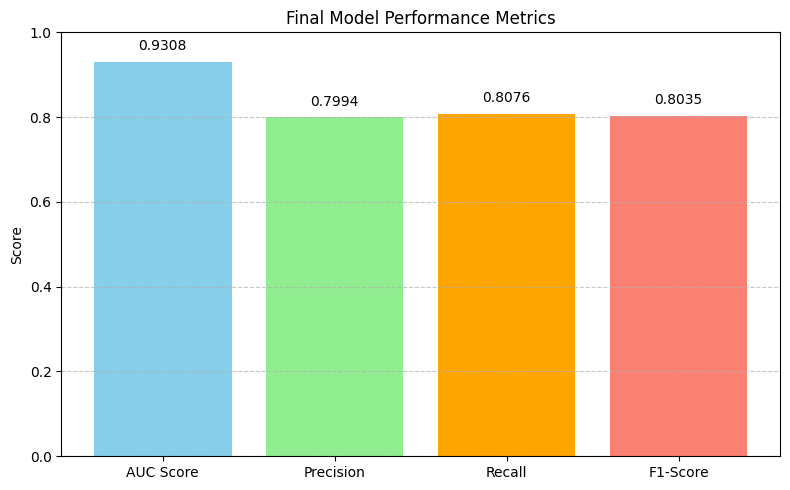

In [27]:
import matplotlib.pyplot as plt

# Define metrics
metrics = {
    'AUC Score': auc_score,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

# Plot
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightgreen', 'orange', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Final Model Performance Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add score values on top of bars
for i, (metric, score) in enumerate(metrics.items()):
    plt.text(i, score + 0.02, f"{score:.4f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


--- Final Model Performance -------

`AUC Score`: 0.9308

`Precision`: 0.7994

`Recall`:    0.8076

`F1-Score`:  0.8035

In [28]:
submission_df = test_df[['customer_id', 'location_number', 'vendor_id']].copy()
submission_df['target'] = test_preds
submission_df['CID X LOC_NUM X VENDOR'] = submission_df['customer_id'].astype(str) + ' X ' + submission_df['location_number'].astype(str) + ' X ' + submission_df['vendor_id'].astype(str)
final_submission = submission_df[['CID X LOC_NUM X VENDOR', 'target']]
final_submission.to_csv('submission_final_optuna.csv', index=False)

print("\nScript finished successfully!")
print("The submission file 'submission_final_optuna.csv' has been generated.")


Script finished successfully!
The submission file 'submission_final_optuna.csv' has been generated.
